<a href="https://colab.research.google.com/github/shengy90/MSc-Project/blob/master/notebooks/PCA%2BAgglomerative_Clustering_12th_July.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **Authenticate with BigQuery ☁️**

In [ ]:
!pip install --upgrade google-cloud-bigquery[bqstorage,pandas]

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%%bigquery --project machine-learning-msc df --use_bqstorage_api
SELECT 
  COUNT(*) as total_rows
FROM `machine-learning-msc.low_carbon_london.household_consumption_daily_agg` 

In [ ]:
df.head()

,total_rows
0,14841792


### **Importing Libraries⏬**

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import random
from tqdm import tqdm
from datetime import date
from matplotlib.gridspec import GridSpec

sns.set()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Downloading Datasets 🚚**
Note - this can take a while to download!


In [ ]:
%%bigquery --project machine-learning-msc df --use_bqstorage_api
SELECT 
*,
ROW_NUMBER() OVER (PARTITION BY lcl_id, month_name ORDER BY dayofweek ASC, hhourly_rank ASC) AS weekly_rank
FROM `machine-learning-msc.low_carbon_london.household_consumption_daily_agg` 
ORDER BY lcl_id, month_name ASC, dayofweek ASC, hhourly_rank ASC

In [ ]:
df.head()

,lcl_id,acorn_grouped,acorn,month_name,dayofweek,hhourly_rank,hh_avg,hh_max,hh_min,hh_stddev,hh_median,hh_quartile_25,hh_quartile_75,weekly_rank
0,MAC000003,Adversity,P,April,1,0,1.92100,3.416,1.409,0.996758,1.4295,1.41575,1.93475,1
1,MAC000003,Adversity,P,April,1,1,1.90075,3.334,1.403,0.955759,1.4330,1.40975,1.92400,2
2,MAC000003,Adversity,P,April,1,2,1.43775,3.051,0.691,1.088403,1.0045,0.85450,1.58775,3
3,MAC000003,Adversity,P,April,1,3,0.60825,2.175,0.069,1.044573,0.0945,0.08550,0.61725,4
4,MAC000003,Adversity,P,April,1,4,0.96275,2.653,0.356,1.127292,0.4210,0.39575,0.98800,5


### **Pivot Dataframe**

In [ ]:
def pivot_table(df):
    return pd.pivot_table(df, values=['hh_avg'], index=['lcl_id'], columns=['month_name','weekly_rank'], aggfunc=np.sum)
df_wide = pivot_table(df)
df_wide.columns = [''.join(str(col)) for col in df_wide.columns]

In [ ]:
df_wide.head()

,"('hh_avg', 'April', 1)","('hh_avg', 'April', 2)","('hh_avg', 'April', 3)","('hh_avg', 'April', 4)","('hh_avg', 'April', 5)","('hh_avg', 'April', 6)","('hh_avg', 'April', 7)","('hh_avg', 'April', 8)","('hh_avg', 'April', 9)","('hh_avg', 'April', 10)","('hh_avg', 'April', 11)","('hh_avg', 'April', 12)","('hh_avg', 'April', 13)","('hh_avg', 'April', 14)","('hh_avg', 'April', 15)","('hh_avg', 'April', 16)","('hh_avg', 'April', 17)","('hh_avg', 'April', 18)","('hh_avg', 'April', 19)","('hh_avg', 'April', 20)","('hh_avg', 'April', 21)","('hh_avg', 'April', 22)","('hh_avg', 'April', 23)","('hh_avg', 'April', 24)","('hh_avg', 'April', 25)","('hh_avg', 'April', 26)","('hh_avg', 'April', 27)","('hh_avg', 'April', 28)","('hh_avg', 'April', 29)","('hh_avg', 'April', 30)","('hh_avg', 'April', 31)","('hh_avg', 'April', 32)","('hh_avg', 'April', 33)","('hh_avg', 'April', 34)","('hh_avg', 'April', 35)","('hh_avg', 'April', 36)","('hh_avg', 'April', 37)","('hh_avg', 'April', 38)","('hh_avg', 'April', 39)","('hh_avg', 'April', 40)",...,"('hh_avg', 'September', 297)","('hh_avg', 'September', 298)","('hh_avg', 'September', 299)","('hh_avg', 'September', 300)","('hh_avg', 'September', 301)","('hh_avg', 'September', 302)","('hh_avg', 'September', 303)","('hh_avg', 'September', 304)","('hh_avg', 'September', 305)","('hh_avg', 'September', 306)","('hh_avg', 'September', 307)","('hh_avg', 'September', 308)","('hh_avg', 'September', 309)","('hh_avg', 'September', 310)","('hh_avg', 'September', 311)","('hh_avg', 'September', 312)","('hh_avg', 'September', 313)","('hh_avg', 'September', 314)","('hh_avg', 'September', 315)","('hh_avg', 'September', 316)","('hh_avg', 'September', 317)","('hh_avg', 'September', 318)","('hh_avg', 'September', 319)","('hh_avg', 'September', 320)","('hh_avg', 'September', 321)","('hh_avg', 'September', 322)","('hh_avg', 'September', 323)","('hh_avg', 'September', 324)","('hh_avg', 'September', 325)","('hh_avg', 'September', 326)","('hh_avg', 'September', 327)","('hh_avg', 'September', 328)","('hh_avg', 'September', 329)","('hh_avg', 'September', 330)","('hh_avg', 'September', 331)","('hh_avg', 'September', 332)","('hh_avg', 'September', 333)","('hh_avg', 'September', 334)","('hh_avg', 'September', 335)","('hh_avg', 'September', 336)"
lcl_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MAC000003,1.92100,1.90075,1.43775,0.60825,0.96275,0.65750,0.73475,0.81425,0.66500,0.95425,0.60100,0.63900,0.78900,0.66200,0.17875,0.29525,0.24475,0.23775,0.22950,0.22425,0.25900,0.43550,0.51550,0.24800,0.35875,0.15375,0.14000,0.09825,0.11700,0.12650,0.12775,0.12350,0.10425,0.11350,0.12125,0.16325,0.17225,0.18425,0.22075,0.19300,...,0.09125,0.21475,0.24775,0.10925,0.20225,0.37575,0.2735,0.21375,0.22900,0.17050,0.12500,0.10350,0.09475,0.07875,0.15875,0.16450,0.12800,0.27050,0.24475,0.13225,0.35450,0.19100,0.11500,0.08525,0.08625,0.10500,0.08625,0.11625,0.15125,0.10725,0.14075,0.19050,0.14125,0.17925,0.09900,0.10675,0.14075,0.08725,0.09200,0.07625
MAC000004,0.04250,0.00000,0.04425,0.01075,0.04125,0.09750,0.00000,0.05325,0.00000,0.04550,0.04375,0.04425,0.00000,0.04250,0.00000,0.09550,0.04375,0.00000,0.04050,0.00000,0.08975,0.04575,0.03375,0.01250,0.00000,0.03750,0.10025,0.00000,0.07575,0.00000,0.01500,0.06925,0.04525,0.00000,0.00000,0.06600,0.06950,0.04675,0.00000,0.00000,...,0.02575,0.08600,0.00000,0.00000,0.00000,0.09175,0.0850,0.00000,0.00000,0.00000,0.04475,0.08825,0.04000,0.00000,0.00000,0.06300,0.03400,0.08375,0.00000,0.00000,0.05050,0.00000,0.08250,0.04275,0.00000,0.00000,0.04775,0.08325,0.05200,0.00000,0.00300,0.02875,0.12100,0.00000,0.00000,0.04750,0.00000,0.09625,0.04825,0.00000
MAC000006,0.02775,0.03900,0.03875,0.03300,0.03325,0.02525,0.03350,0.02725,0.02700,0.02800,0.02825,0.04175,0.05800,0.08525,0.08225,0.07925,0.17550,0.14475,0.06725,0.07100,0.02425,0.03425,0.03125,0.01875,0.05425,0.07950,0.04175,0.05125,0.03450,0.05400,0.04600,0.03950,0.04025,0.04675,0.06150,0.06625,0.06675,0.07575,0.06950,0.09325,

### **PCA**

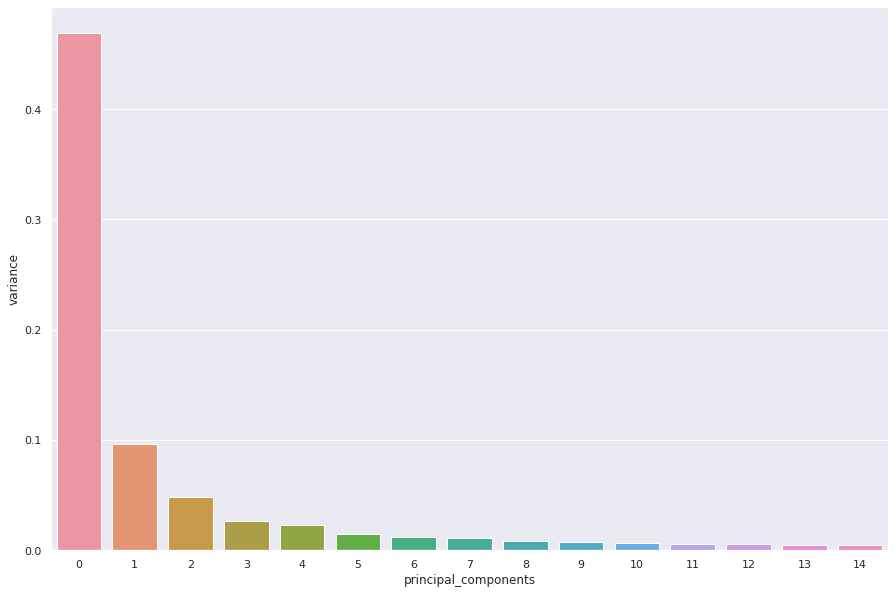

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

normalised_df = StandardScaler().fit_transform(df_wide)
pca = PCA(n_components=15)
principal_components = pca.fit_transform(normalised_df)
pca_df = pd.DataFrame(
    {'variance' : pca.explained_variance_ratio_,
     'principal_components': range(pca.n_components)}
     )
plt.figure(figsize=(15, 10))
sns.barplot(x='principal_components', y='variance', data=pca_df)

**Take the first 5 principal components** 

In [ ]:
pca_components = pd.DataFrame(
    index=df_wide.index,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15'],
    data = principal_components
    )
df_pca = pca_components[['PC1', 'PC2', 'PC3','PC4','PC5']].copy()

### **Hierarchical Clustering**

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=25).fit(df_pca) ## 25 clusters to compare against SOM

In [ ]:
df_pca_labelled = df_pca.copy()
df_pca_labelled['cluster'] = cluster.labels_
df_pca_labelled['cluster'] = pd.Categorical(df_pca_labelled['cluster'])
df_pca_labelled.reset_index(inplace=True)

In [ ]:
df_pca_labelled.groupby('cluster').count()

,lcl_id,PC1,PC2,PC3,PC4,PC5
cluster,,,,,,
0,557,557,557,557,557,557
1,117,117,117,117,117,117
2,7,7,7,7,7,7
3,114,114,114,114,114,114
4,8,8,8,8,8,8
5,31,31,31,31,31,31
6,713,713,713,713,713,713
7,220,220,220,220,220,220
8,27,27,27,27,27,27


In [ ]:
 def cluster_x_coord(cluster):
     return np.floor(cluster/5).astype(int)

def cluster_y_coord(cluster):
    return np.mod(cluster,5).astype(int)

df_pca_labelled['cluster_x'] = df_pca_labelled['cluster'].apply(cluster_x_coord)
df_pca_labelled['cluster_y'] = df_pca_labelled['cluster'].apply(cluster_y_coord)
df_pca_labelled.head(10)

,lcl_id,PC1,PC2,PC3,PC4,PC5,cluster,cluster_x,cluster_y
0,MAC000003,53.918812,149.681856,2.976630,10.343288,17.117905,15,3,0
1,MAC000004,-49.622535,6.147492,-2.334521,3.154766,1.197664,16,3,1
2,MAC000006,-43.804590,2.460029,-3.115291,3.341718,1.567527,16,3,1
3,MAC000007,-6.351316,-9.011416,-1.628710,1.846662,3.328950,18,3,3
4,MAC000008,46.686881,-1.278316,1.878151,1.509332,8.036679,1,0,1
5,MAC000009,-11.101347,-7.155309,-1.346080,3.347693,11.555667,18,3,3
6,MAC000010,91.295314,-29.544145,10.529145,-5.771824,2.837477,8,1,3
7,MAC000013,-29.004980,5.088326,-1.737019,-0.232532,-1.147551,16,3,1
8,MAC000018,5.660040,11.858433,10.684101,-4.242561,-3.085960,0,0,0
9,MAC000019,-22.420905,-1.936817,1.321498,5.319264,4.896853,18,3,3


In [ ]:
df_pca_labelled.groupby(['cluster_x','cluster_y'])['lcl_id'].nunique()

cluster_x  cluster_y
0          0            557
           1            117
           2              7
           3            114
           4              8
1          0             31
           1            713
           2            220
           3             27
           4              7
2          0             37
           1              4
           2            202
           3              1
           4              1
3          0             18
           1            663
           2             10
           3            551
           4             52
4          0              6
           1             66
           2             61
           3            182
           4             26
Name: lcl_id, dtype: int64

### **Plot Load Profiles**

In [ ]:
cluster_df = df.merge(df_pca_labelled, on='lcl_id')

In [54]:
def pick_random_lclids(df, num, position=None):
    """
    Function to pick random `num` lcl_ids from dataset
    Parameters:
        df : input dataframe 
        num: number of lcl_ids to output
    """
    if position is None:
        all_lcl_ids = list(set(df['lcl_id']))
    else:
        all_lcl_ids = list(set(df.query(f"cluster_x=={position[0]} and cluster_y=={position[1]}")['lcl_id']))
    
    try:
        id_list = np.random.choice(all_lcl_ids, num, replace=False) 
    except:
        print("\nWARN: SAMPLING WITH REPLACEMENT")
        id_list = np.random.choice(all_lcl_ids, num, replace=True)
    
    return id_list 


def get_load_profile(df, lcl_id, month):
    return df.query((f"lcl_id=='{lcl_id}' and month_name == '{month}'"))[['weekly_rank','hh_avg']]

In [55]:
def plot_clusters(cluster_df, month):
    print(f"\nPlotting load profiles for {month}\n")

    plt.figure(figsize=(48, 16))
    the_grid = GridSpec(5, 5)

    for pos_i in tqdm(range(5)):
        for pos_j in range(5):
            plt.subplot(the_grid[pos_i, pos_j])
            lcl_ids = pick_random_lclids(cluster_df, 3, position=(pos_i,pos_j))
            for lcl_id in lcl_ids:
                load_profile = get_load_profile(cluster_df,lcl_id, month)
                plt.plot(load_profile['weekly_rank'], load_profile['hh_avg'], alpha=.5)


  0%|          | 0/5 [00:00<?, ?it/s]


Plotting load profiles for January




 40%|████      | 2/5 [00:18<00:27,  9.01s/it]

WARN: SAMPLING WITH REPLACEMENT
WARN: SAMPLING WITH REPLACEMENT



100%|██████████| 5/5 [00:44<00:00,  8.90s/it]


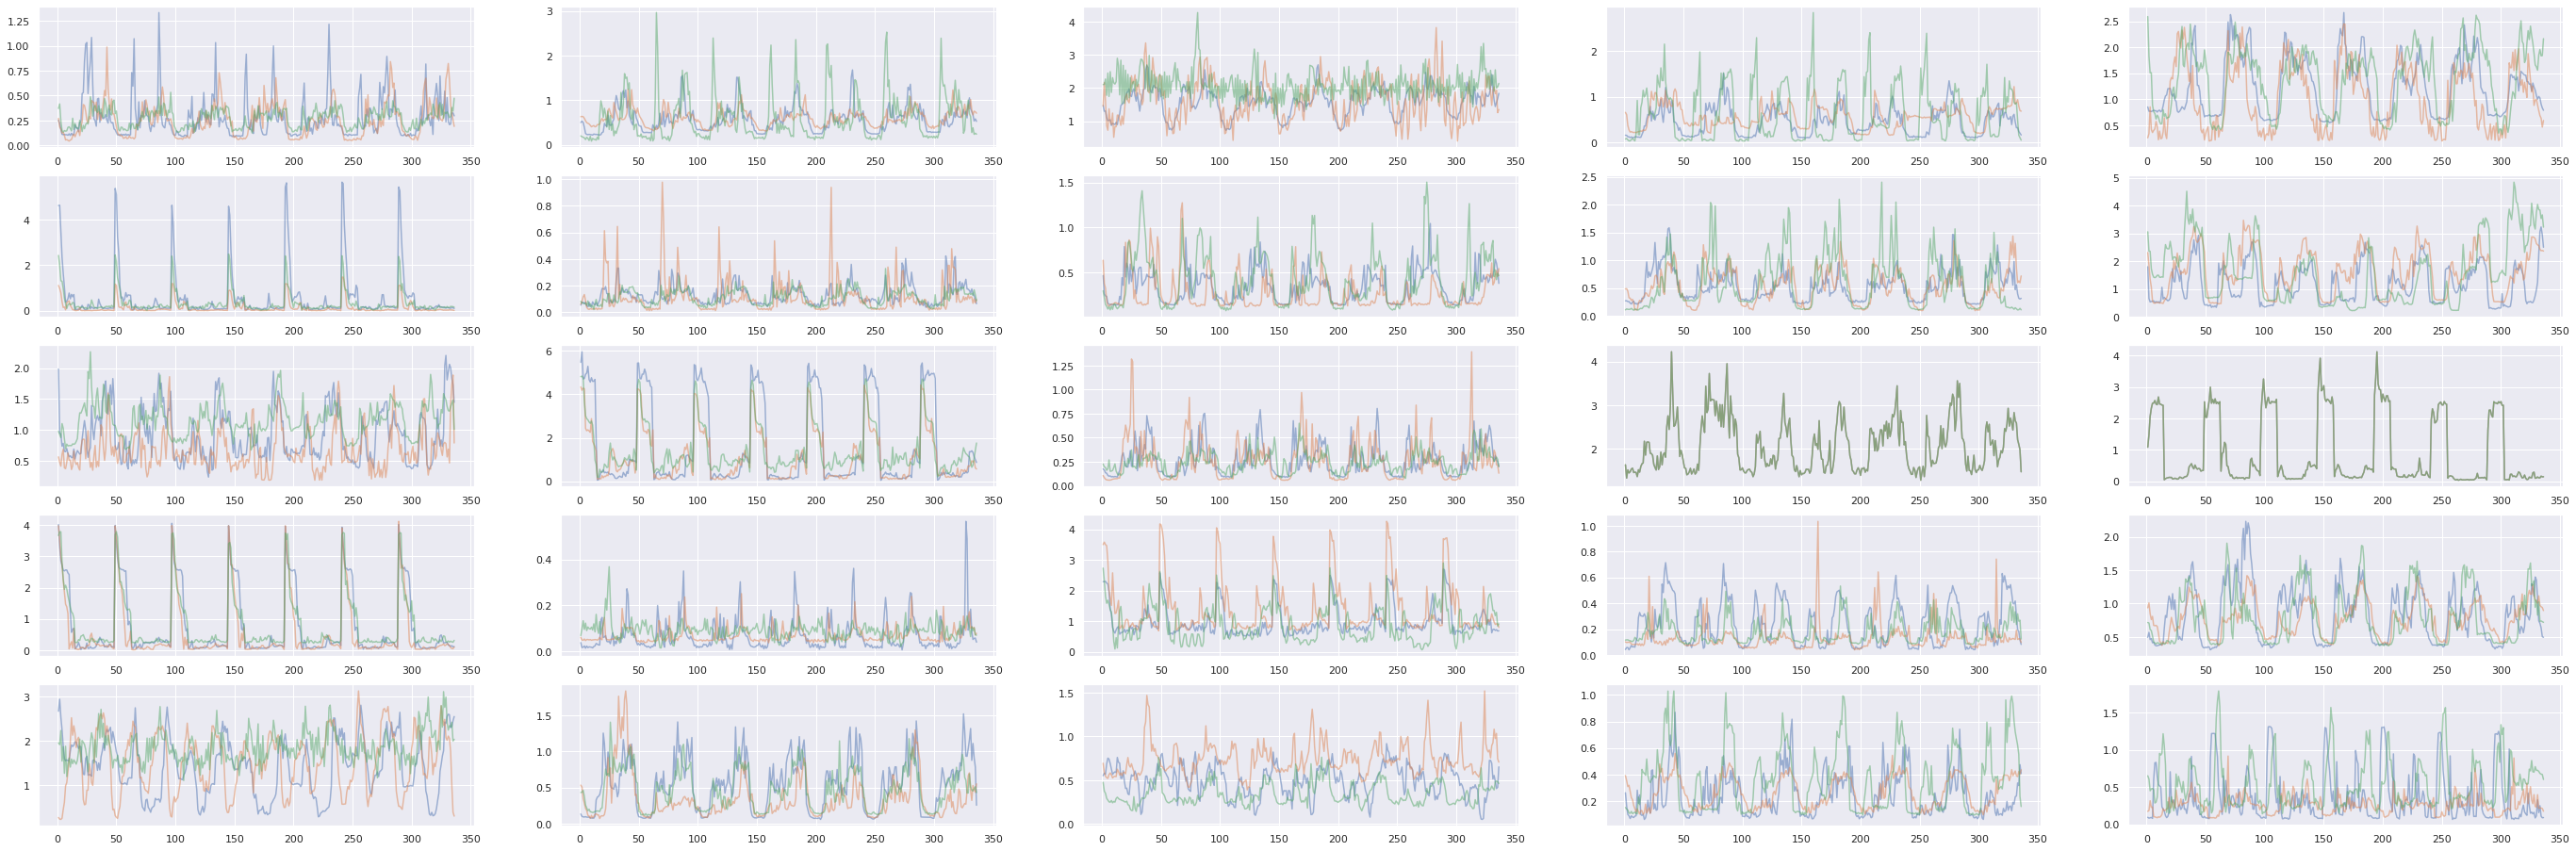

In [56]:
plot_clusters(cluster_df, 'January')


  0%|          | 0/5 [00:00<?, ?it/s]


Plotting load profiles for March




 40%|████      | 2/5 [00:18<00:28,  9.34s/it]

WARN: SAMPLING WITH REPLACEMENT
WARN: SAMPLING WITH REPLACEMENT



100%|██████████| 5/5 [00:45<00:00,  9.15s/it]


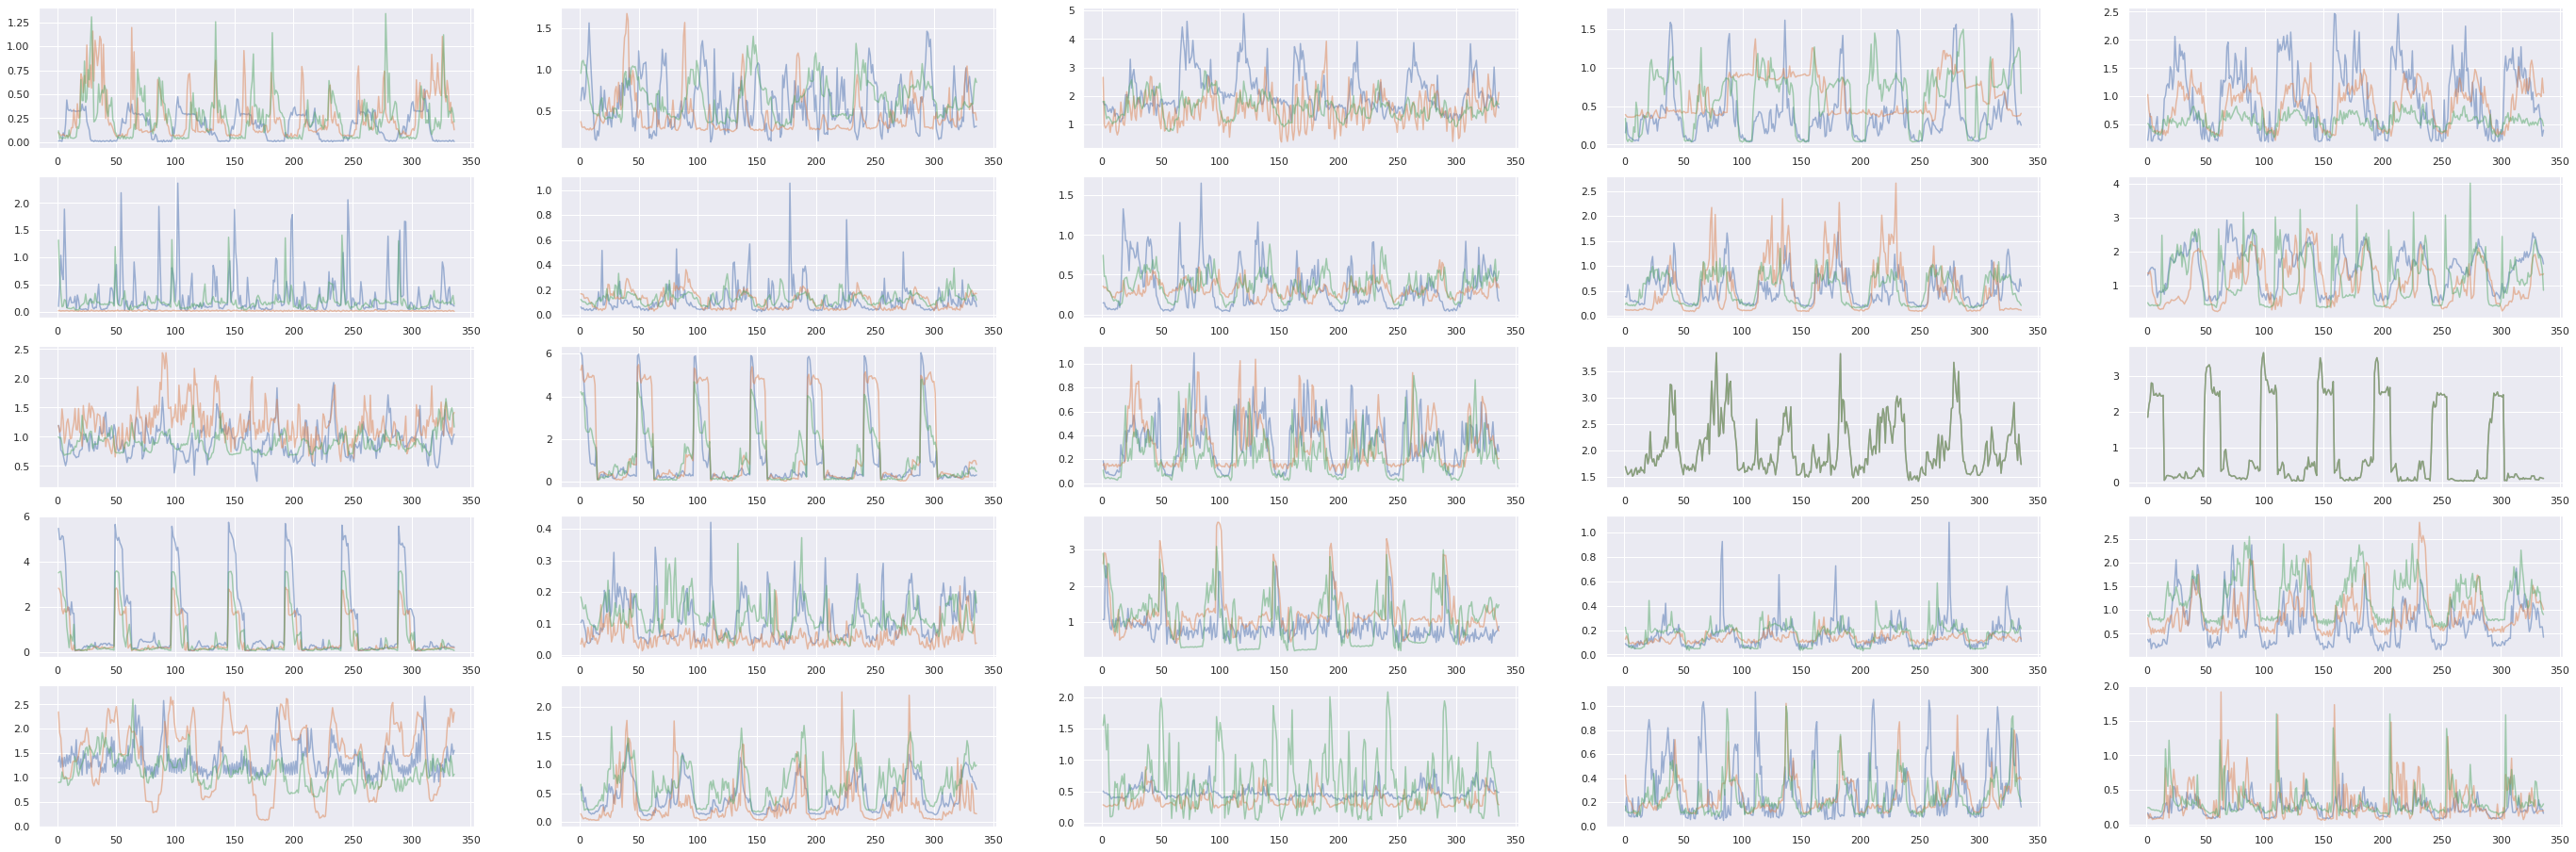

In [57]:
plot_clusters(cluster_df, 'March')


  0%|          | 0/5 [00:00<?, ?it/s]


Plotting load profiles for July




 40%|████      | 2/5 [00:17<00:26,  8.68s/it]

WARN: SAMPLING WITH REPLACEMENT
WARN: SAMPLING WITH REPLACEMENT



100%|██████████| 5/5 [00:43<00:00,  8.64s/it]


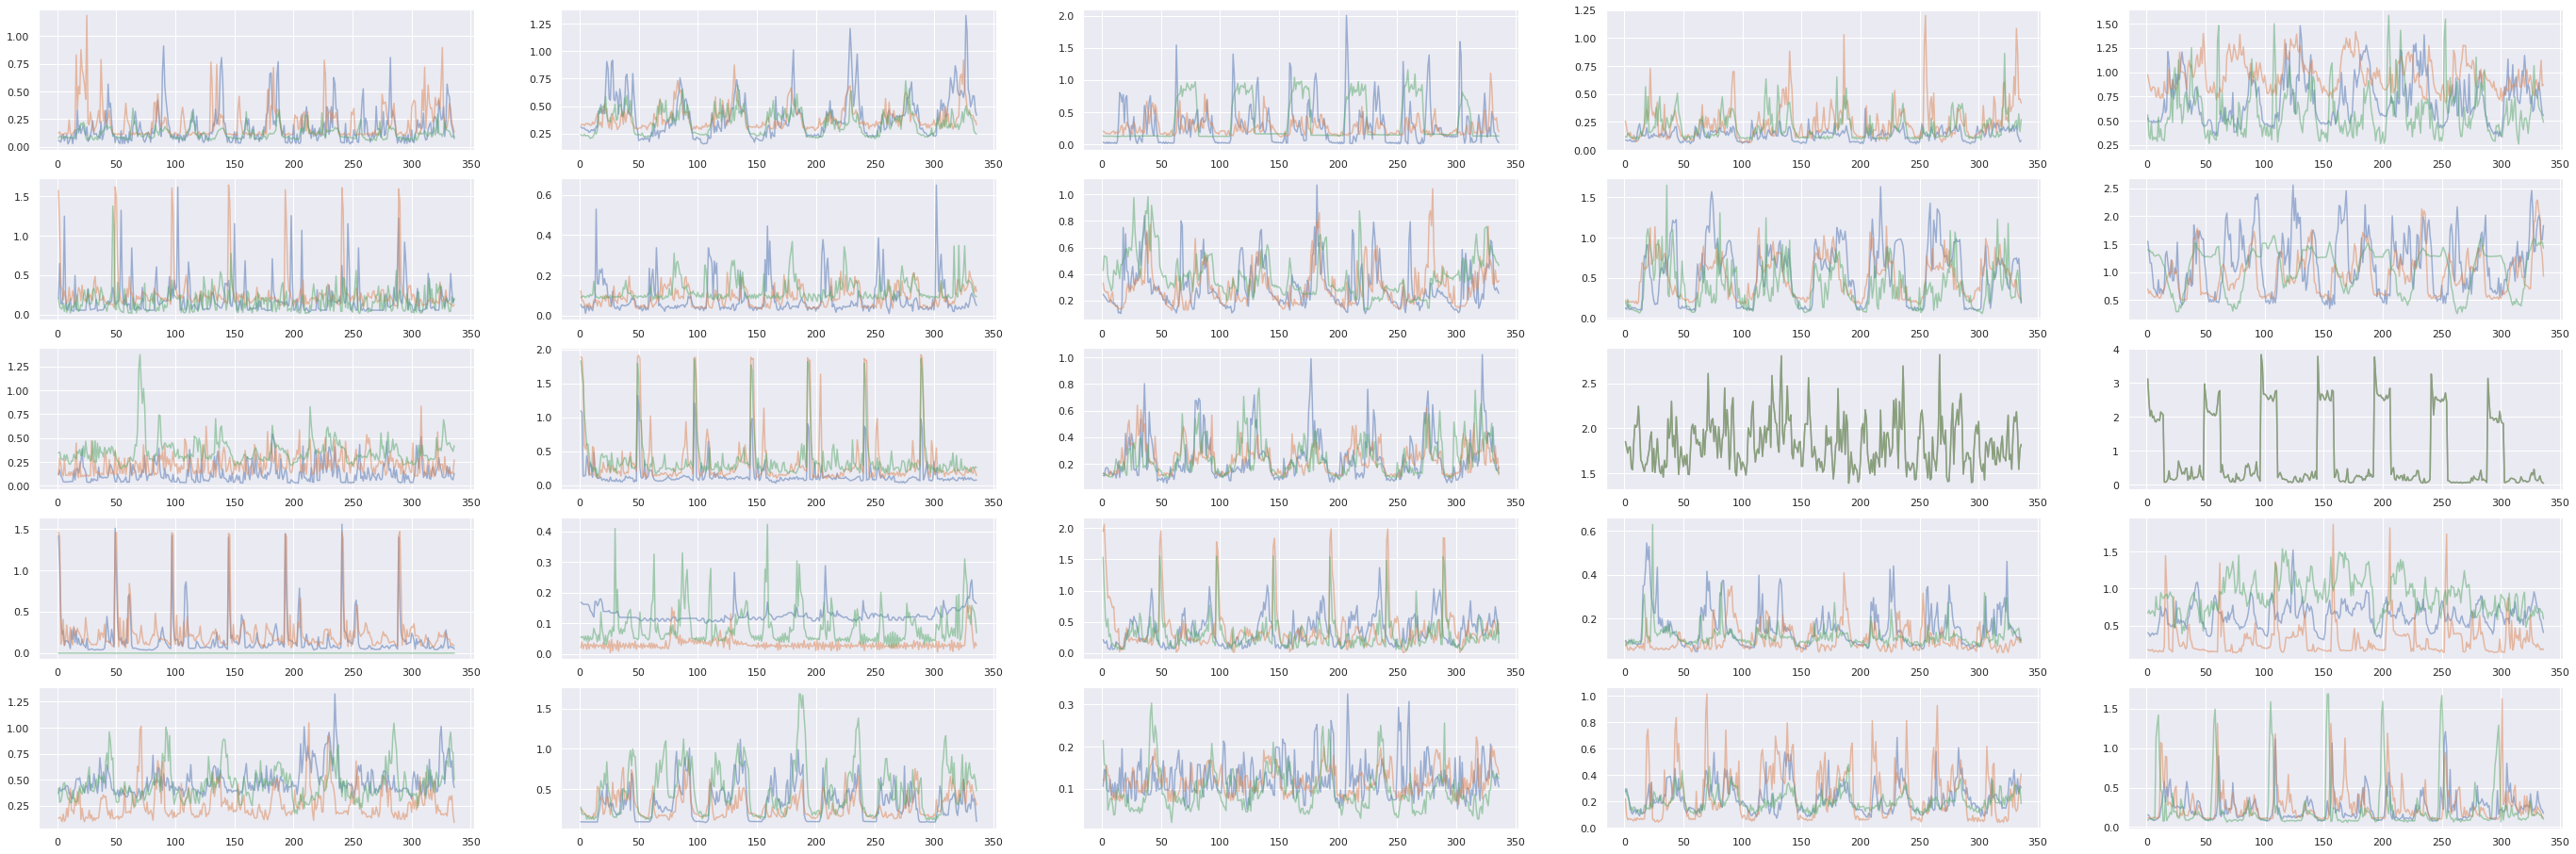

In [58]:
plot_clusters(cluster_df, 'July')

### **Distribution of Acorn groups in each cluster**

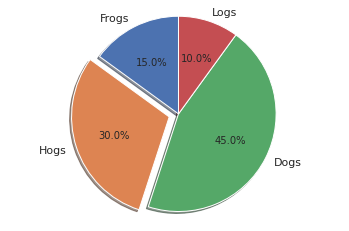

In [61]:
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [99]:
pie_chart_df = pd.DataFrame(cluster_df.groupby(['cluster_x','cluster_y','acorn_grouped'])['lcl_id'].nunique())
pie_chart_df.reset_index(inplace=True)
pie_chart_df = pd.pivot_table(pie_chart_df, values='lcl_id', index=['cluster_x','cluster_y'], columns=['acorn_grouped'], aggfunc=np.sum)
pie_chart_df.reset_index(inplace=True)
pie_chart_df.fillna(0, inplace=True)

In [114]:
import matplotlib.gridspec as gridspec

def plot_pie_chart(df):
    plt.figure(figsize=(10,10))
    grid = gridspec.GridSpec(5, 5)
    for pos_i in tqdm(range(5)):
        for pos_j in range(5):
            plt.subplot(grid[pos_i, pos_j])
            pie = df.query(f"cluster_x=={pos_i} and cluster_y=={pos_j}")[['ACORN-U', 'Adversity', 'Affluent', 'Comfortable']].values.tolist()[0]
            patches = plt.pie(pie)

    labels = pie_chart_df.query('cluster_x==0 and cluster_y == 0')[['ACORN-U', 'Adversity', 'Affluent', 'Comfortable']].columns.tolist()
    print(labels)
    plt.legend(labels, bbox_to_anchor=(0.5, 6.5), ncol=4)
    plt.show()


100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


['ACORN-U', 'Adversity', 'Affluent', 'Comfortable']


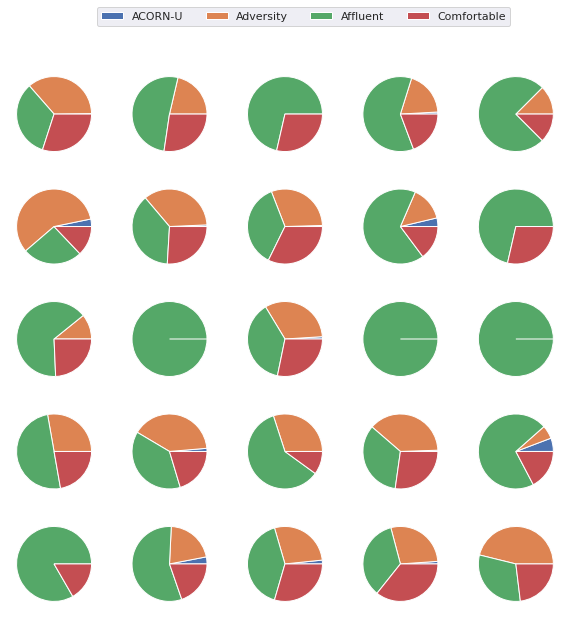

In [115]:
plot_pie_chart(pie_chart_df)